### Using the temporal nets to analyse the burst dynamics of links 

Analysis of the burst dynamics of each link for each frequency band and stage of the ODRT.

In [1]:
# Adding GDa to path
import sys
sys.path.insert(1, '/home/vinicius/GrayData-Analysis')
# Importing the temporal network class
from   GDa.temporal_network              import temporal_network
from   GDa.spectral_analysis             import filtering, time_frequency
from   GDa.misc.create_grids             import create_stages_time_grid
from   tqdm                              import tqdm
from   joblib                            import Parallel, delayed
from   GDa.graphics.plot_brain_sketch    import *
from   GDa.misc.create_grids             import create_stages_time_grid
from   GDa.session                       import session
from   scipy                             import stats
import numpy             as     np
import matplotlib.pyplot as     plt
import scipy.signal
import time

In [2]:
def find_activation_sequences(spike_train):
    # make sure all runs of ones are well-bounded
    bounded = np.hstack(([0], spike_train, [0]))
    # get 1 at run starts and -1 at run ends
    difs    = np.diff(bounded)
    run_starts, = np.where(difs > 0)
    run_ends,   = np.where(difs < 0)
    act_lengths =  run_ends - run_starts  # Length of each activation sequence
    return act_lengths
    
def count_activations(spike_train):
    act_lengths = find_activation_sequences(spike_train)
    mu, sigma   = act_lengths.mean(), act_lengths.std()
    return mu, sigma, sigma/mu 

# Auxiliary function to smooth
def smooth(x, w):
    return scipy.signal.fftconvolve(x, np.ones(w)/w, mode='same')

# Bands names
bands = [r'$\theta$', r'$\alpha$', r'$\beta$', r'low-$\gamma$ ', r'high-$\gamma$' ]
stages= ['baseline', 'cue', 'delay', 'match']

When instantiated, the temporal network object will load the recording info for the monkey, date, and sesion specified as well as the super tensor;

The super-tensor has dimensions [Number of pairs, Number of frequency bands, Number of trials * Time] (i.e., the trials are concatenated). So far we are using the following bands:

- $\theta$  = [4,7]  Hz;
- $\alpha$  = [8,14]  Hz;
- $\beta$   = [16,34]  Hz;
- low-$\gamma$  = [40,70]  Hz;
- high-$\gamma$  = [70,100]  Hz;

Band ranges from: https://doi.org/10.1016/j.neuron.2016.02.028 

In [3]:
# Instantiating a temporal network object specifing trim_borders and wt.
net =  temporal_network(raw_path = '../super_tensors/', monkey='lucy', session=1, date=150128, align_to = 'cue', 
                        trial_type = 1, behavioral_response = 1, trim_borders=True, wt_0=20, wt_1=30)

#### X, Y coordinates of each node

In [4]:
xy   = scipy.io.loadmat('../Brain Areas/lucy_brainsketch_xy.mat')['xy'] # Channels coordinates
d_eu = np.zeros(net.session_info['pairs'].shape[0])
for i in range(net.session_info['pairs'].shape[0]):
    c1, c2 = net.session_info['channels_labels'].astype(int)[net.session_info['pairs'][i,0]], net.session_info['channels_labels'].astype(int)[net.session_info['pairs'][i,1]]
    dx = xy[c1-1,0] - xy[c2-1,0]
    dy = xy[c1-1,1] - xy[c2-1,1]
    d_eu[i] = np.sqrt(dx**2 + dy**2)

Now let's plot the super tensor for the first ten trials again and observe that now the vertical stripes are gone.

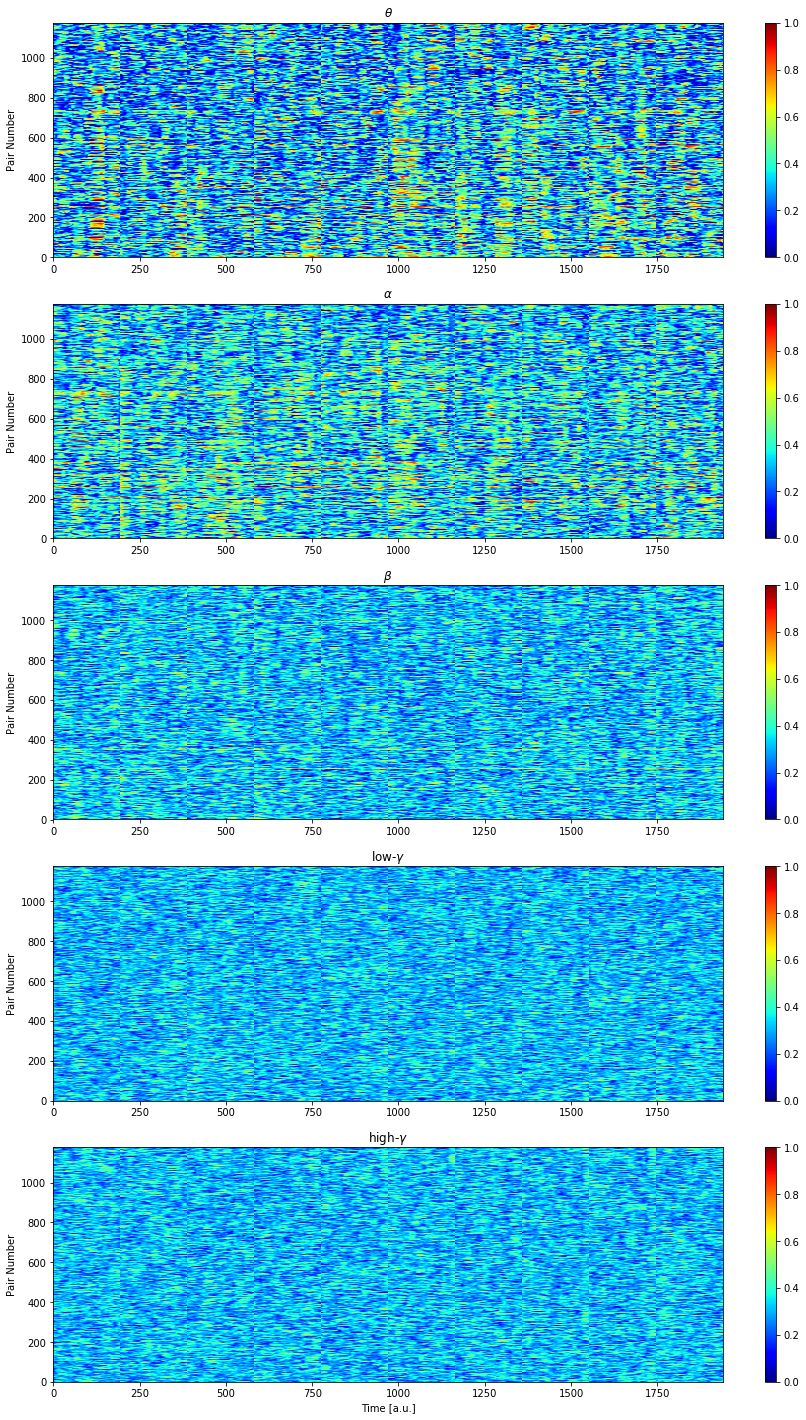

In [5]:
plt.figure(figsize=(15,25))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    plt.imshow(net.super_tensor[:,i,:10*len(net.tarray)], aspect = 'auto', cmap = 'jet', origin = 'lower', 
               extent = [0, 10*len(net.tarray), 1, net.session_info['nP']], vmin = 0, vmax = 1)
    plt.colorbar()
    plt.ylabel('Pair Number')
    if i == 4: plt.xlabel('Time [a.u.]')
    plt.title(bands[i])

#### Mask to track observations within a task-stage

In [6]:
# Mask to track each stage of the ODRT
t_mask = create_stages_time_grid(net.session_info['t_cue_on'], net.session_info['t_cue_off'], 
                                 net.session_info['t_match_on'], net.session_info['fsample'], 
                                 net.tarray, net.session_info['nT'])

### Relative threshold

100%|██████████| 4/4 [02:36<00:00, 39.21s/it]


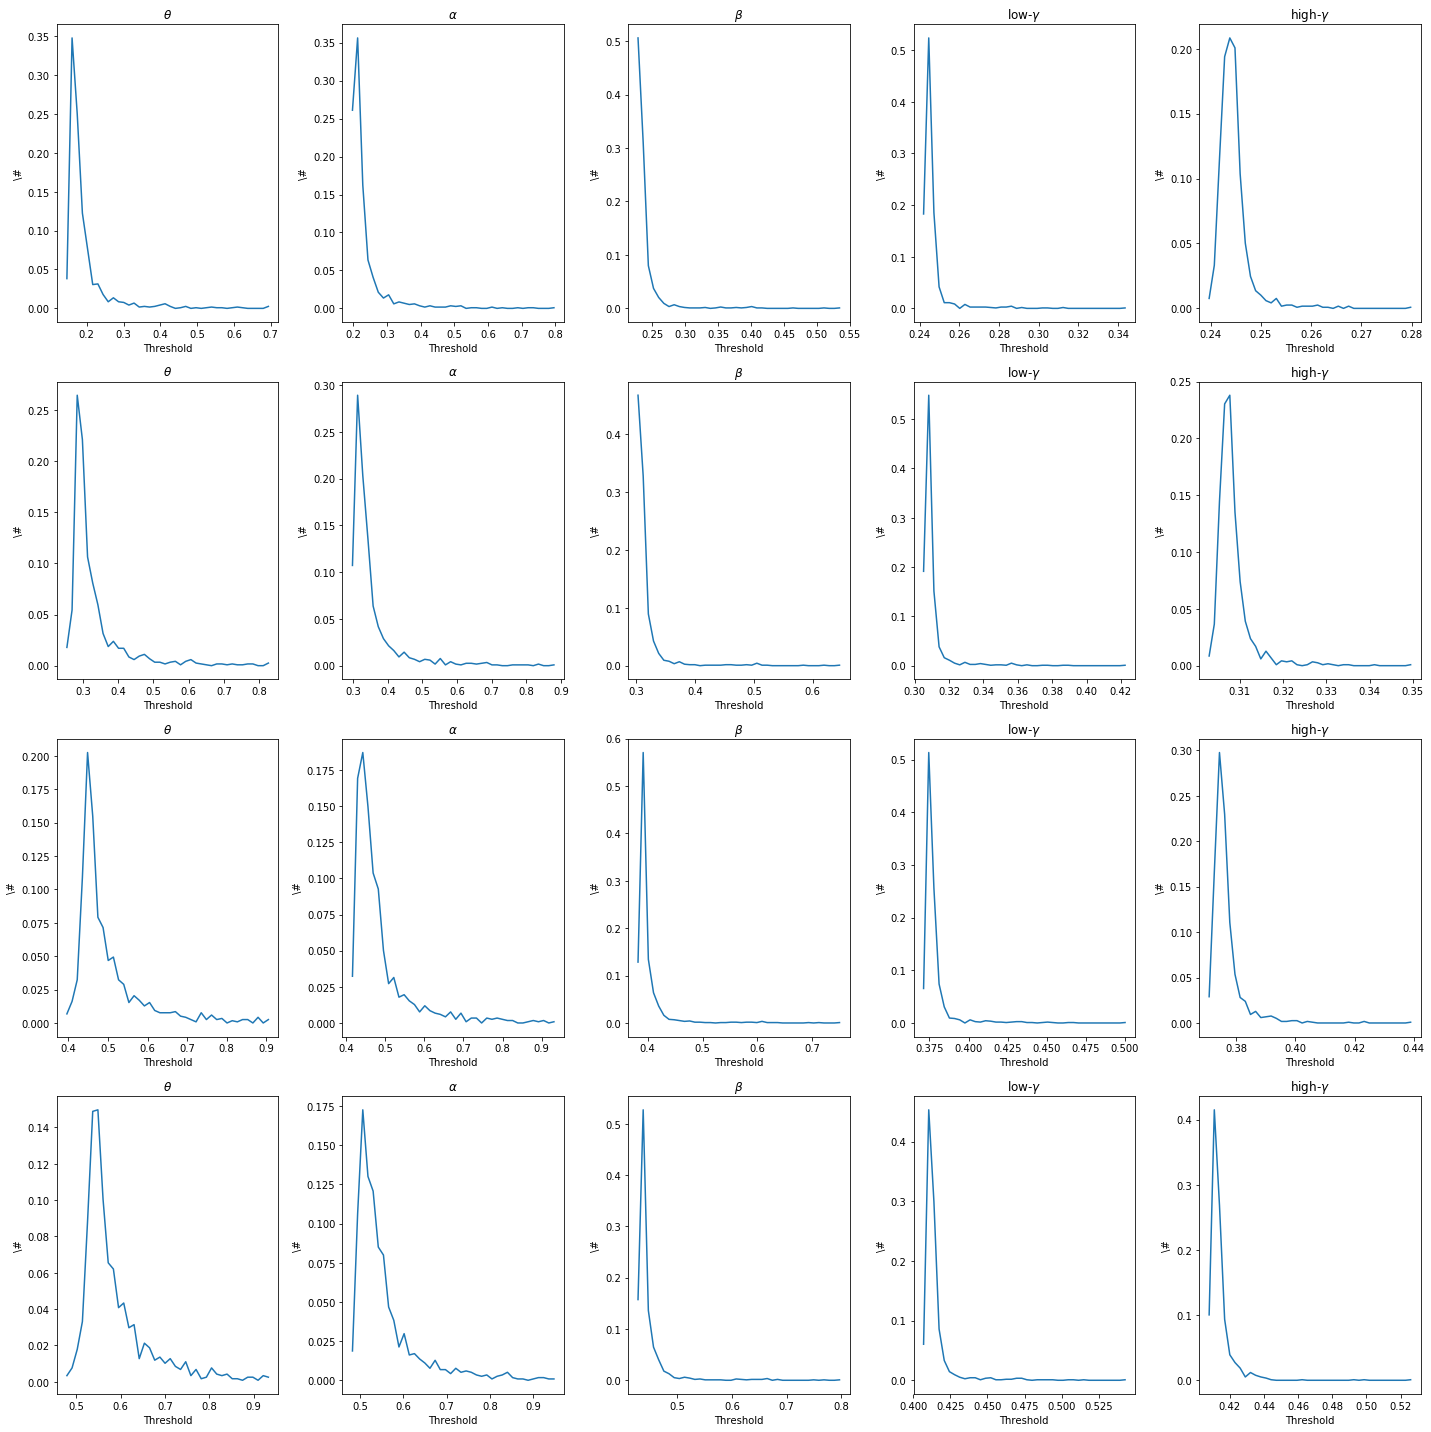

In [7]:
probs = [0.2, 0.5, 0.8, 0.9]
plt.figure(figsize=(20,20))
count = 1
for j in tqdm( range(len(probs)) ):
    for i in range(len(net.bands)):
        plt.subplot(len(probs),len(net.bands),count)
        thr = scipy.stats.mstats.mquantiles(net.super_tensor[:,i,:], prob=probs[j], axis=1)
        c, x = np.histogram(thr, 40)
        c    = c/c.sum()
        plt.plot(x[1:], c)
        plt.title(bands[i])
        plt.xlabel('Threshold')
        plt.ylabel('\#')
        count += 1
plt.tight_layout()

In [9]:
# THRESHOLD 
q_thr = .80

In [10]:
STb = np.zeros_like(net.super_tensor)
for i in tqdm( range(len(net.bands)) ):
    thr = scipy.stats.mstats.mquantiles(net.super_tensor[:,i,:], prob=q_thr, axis=1)
    STb[:,i,:] = net.super_tensor[:,i,:] > thr

100%|██████████| 5/5 [00:40<00:00,  8.19s/it]


100%|██████████| 5/5 [00:00<00:00, 43.41it/s]


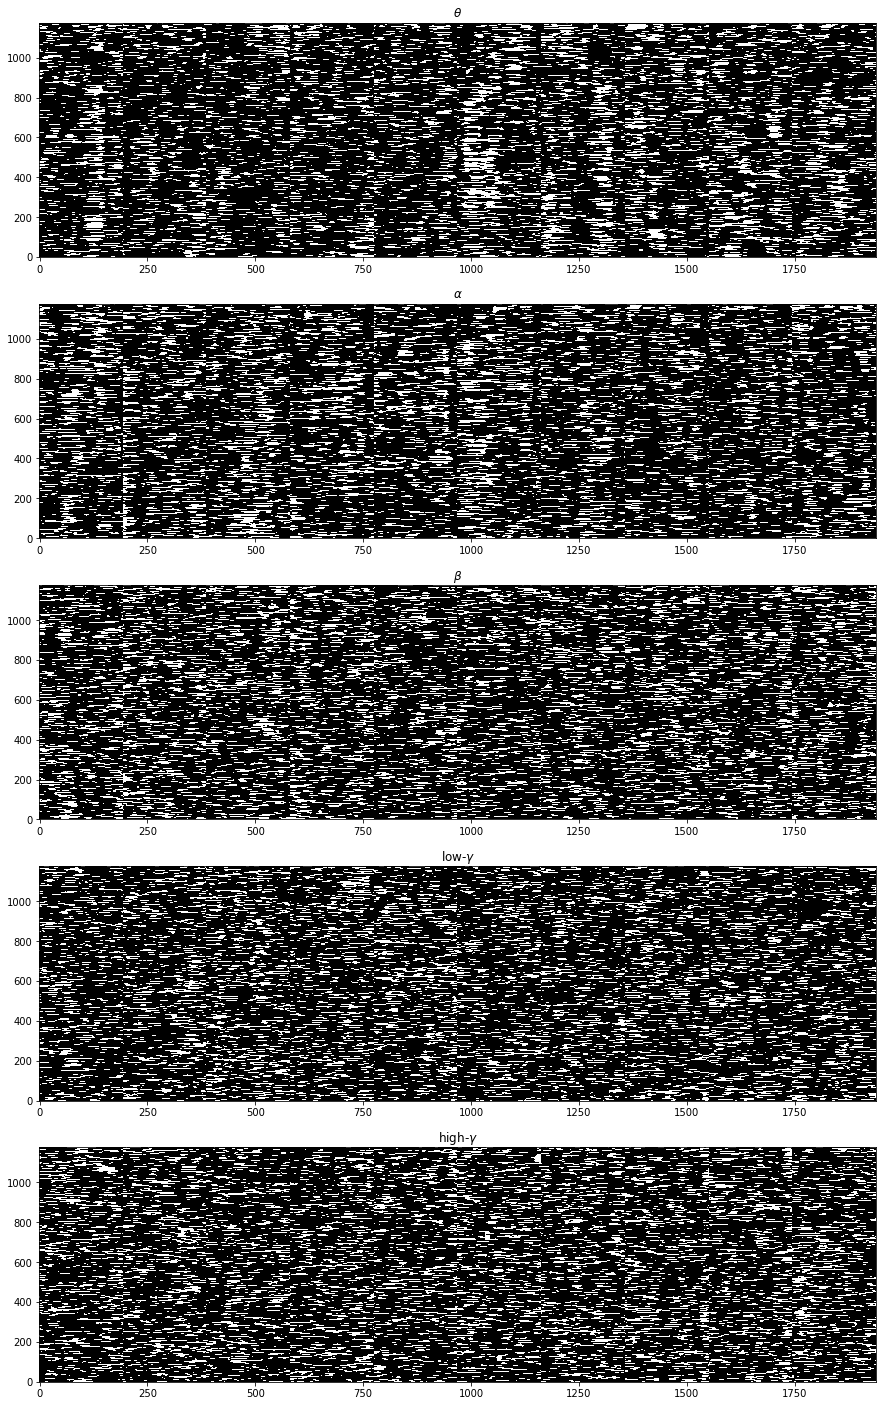

In [11]:
plt.figure(figsize=(15,25))
for i in tqdm( range(len(net.bands)) ):
    plt.subplot(5,1,i+1)
    plt.imshow(STb[:,i,:10*len(net.tarray)], aspect='auto', cmap='gray', origin = 'lower')
    plt.title(bands[i])

100%|██████████| 5/5 [00:23<00:00,  4.70s/it]


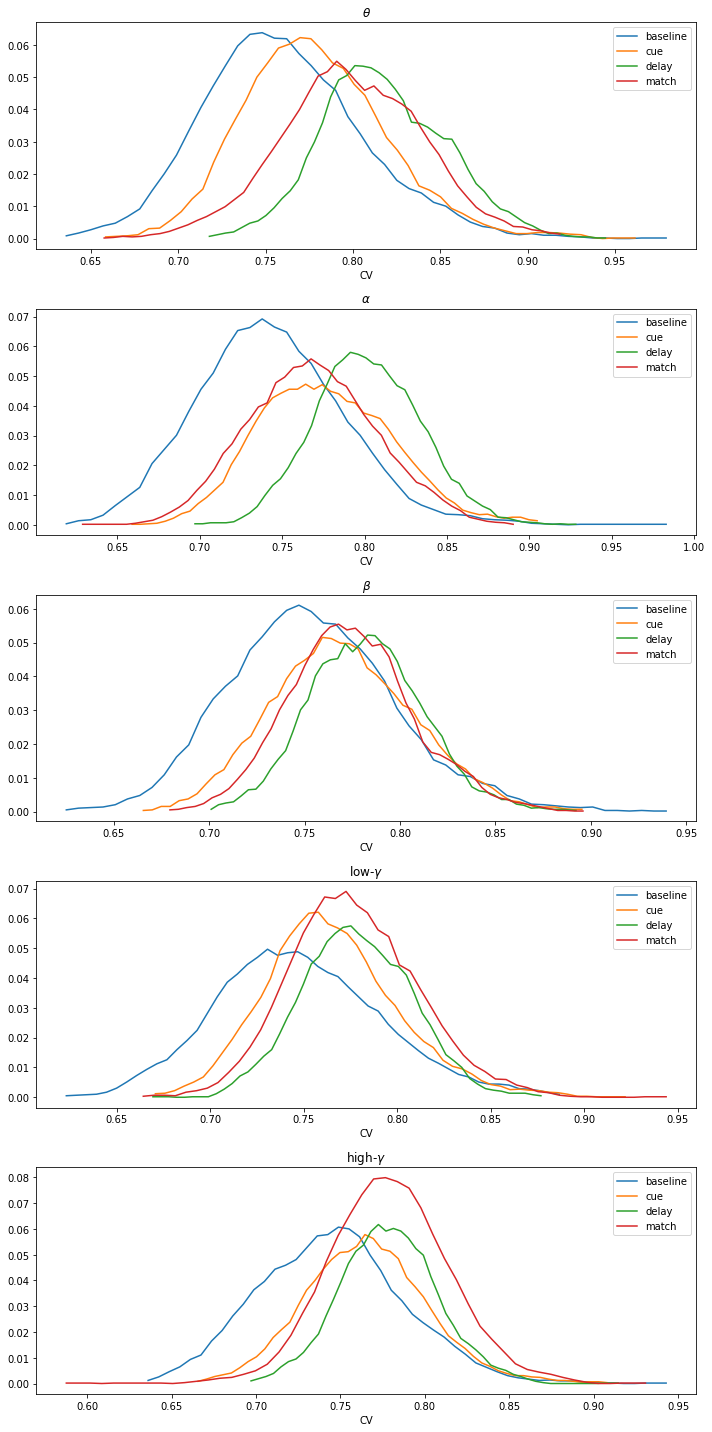

In [11]:
plt.figure(figsize=(10,20))
for i in tqdm( range(len(net.bands)) ):
    b  = {}
    plt.subplot(5,1,i+1)
    for j in range(len(stages)):
        b[stages[j]]  = np.zeros([STb.shape[0], 3])
        b[stages[j]]  = np.apply_along_axis(count_activations, 1, STb[:,i,t_mask[j]])
        aux = b[stages[j]][:,1]/b[stages[j]][:,0]
        c, x = np.histogram(aux, 50)
        c    = c/c.sum()
        plt.plot(x[1:], smooth(c,5), label = stages[j])
    plt.legend()
    plt.xlabel('CV')
    plt.title(bands[i])
plt.tight_layout()

100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


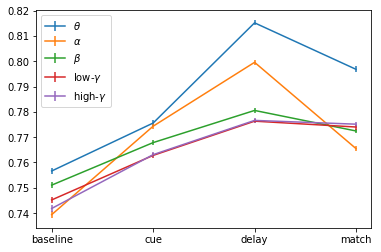

In [12]:
for j in range(len(bands)):
    for i in tqdm(range(len(stages))):
        b[stages[i]]  = np.zeros([STb.shape[0], 3])
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[i]])

    p=b['baseline'][:,2]
    c=b['cue'][:,2]
    d=b['delay'][:,2]
    m=b['match'][:,2]

    plt.errorbar(range(4), [p.mean(), c.mean(), d.mean(), m.mean()], 
                 [p.std()/np.sqrt(1176), c.std()/np.sqrt(1176), d.std()/np.sqrt(1176), m.std()/np.sqrt(1176)])
    plt.xticks(range(4), ['baseline', 'cue', 'delay', 'match'])
plt.legend(bands)

In [13]:
CVm = np.zeros([49, 49, len(bands), len(stages)]) 
b['delay'].shape
for k in tqdm( range(len(bands)) ):
    for i in range(len(stages)):
        aux  = np.apply_along_axis( count_activations, 1, STb[:,k,t_mask[i]])
        for j in range( net.session_info['pairs'].shape[0]):
            CVm[net.session_info['pairs'][j,0], net.session_info['pairs'][j,1], k, i] = aux[j,2]

100%|██████████| 5/5 [00:16<00:00,  3.30s/it]


100%|██████████| 5/5 [00:00<00:00,  6.10it/s]


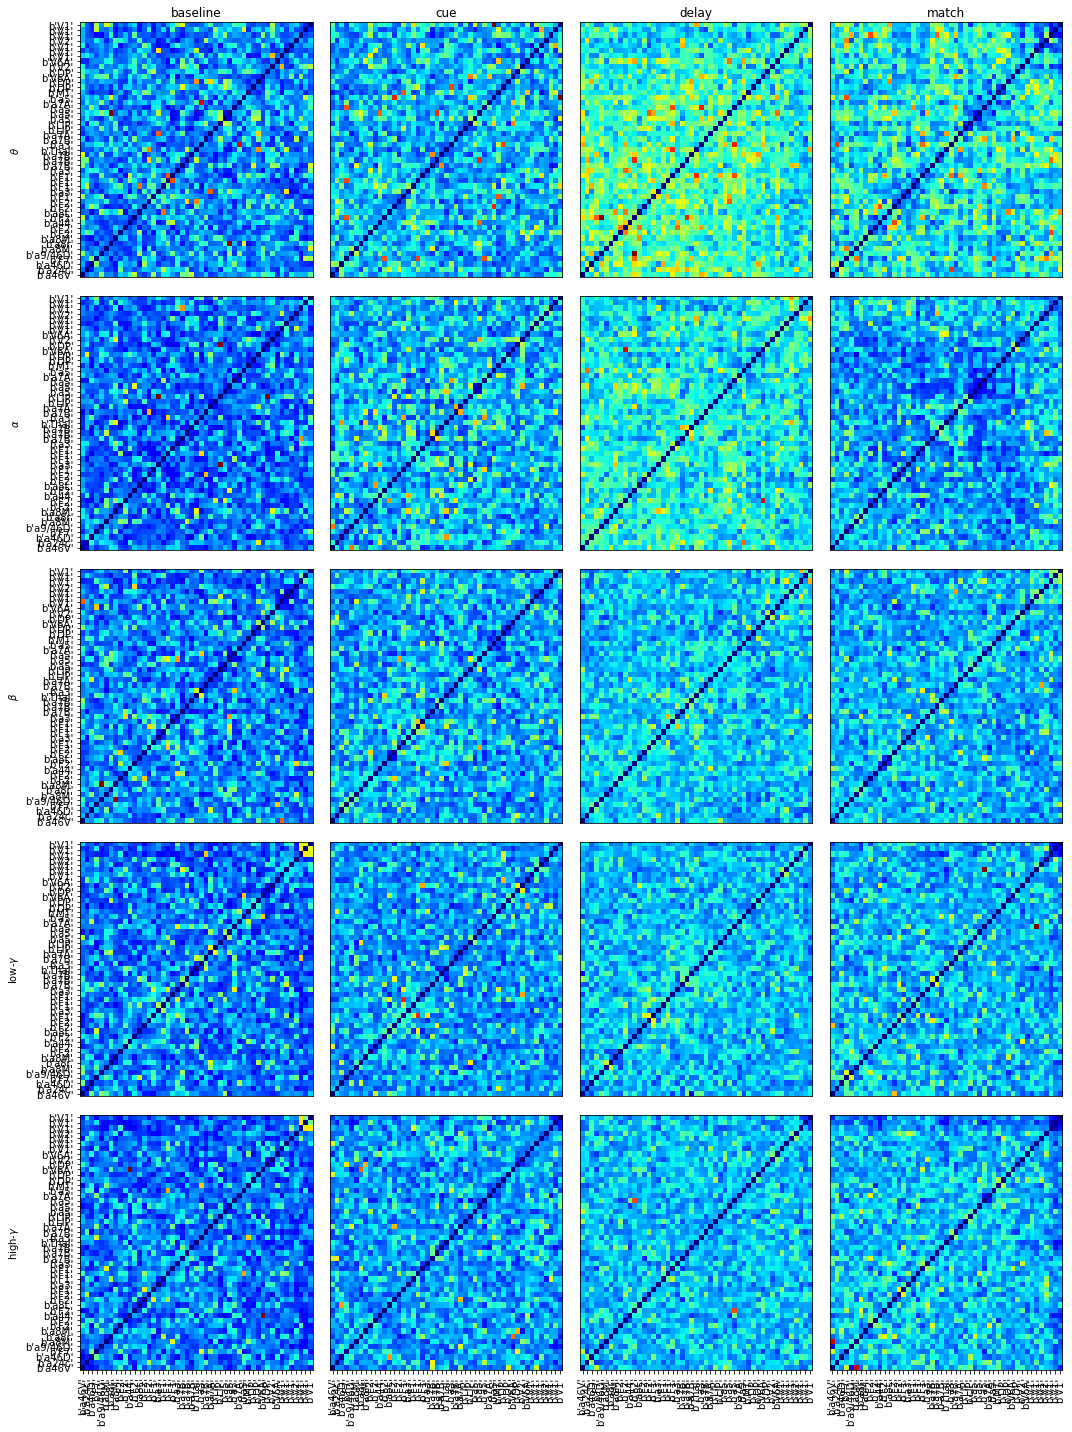

In [14]:
plt.figure(figsize=(15,20))
count = 1
for k in tqdm( range(len(bands)) ):
    for i in range(len(stages)):
        plt.subplot(len(bands),len(stages),count)
        aux = (CVm[:,:,k,i]+CVm[:,:,k,i].T) 
        plt.imshow(aux**6, aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=.7)
        if stages[i] == 'baseline': plt.yticks(range(49), net.session_info['areas'])
        else: plt.yticks([])
        if k == 4: plt.xticks(range(49), net.session_info['areas'], rotation=90)
        else: plt.xticks([])
        if k == 0: plt.title(stages[i])
        if stages[i] == 'baseline': plt.ylabel(bands[k])
        #plt.colorbar()
        count+=1
plt.tight_layout()

#### Top 20 most active links


100%|██████████| 5/5 [01:07<00:00, 13.50s/it]


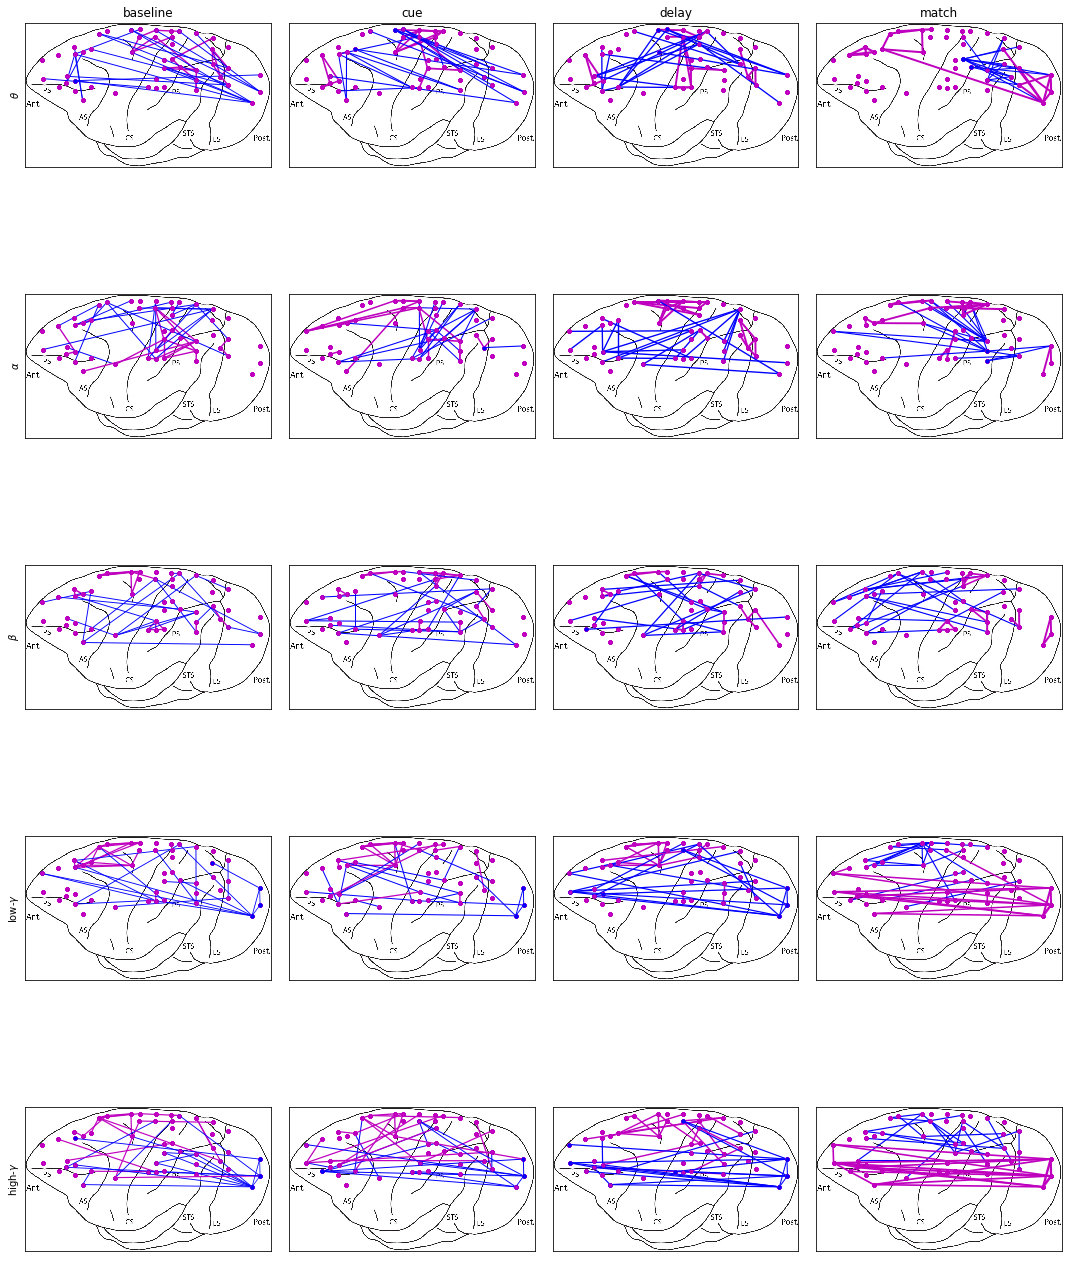

In [51]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b  = {}
    for i in range(len(stages)):     
        # Computing links' CV
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[i]])
        # Plotting top links
        plt.subplot(len(bands), len(stages), count)
        # Top 20 links
        top  = b[stages[i]][:,0].argsort()[:20]
        idx1 = np.zeros(b[stages[i]][:,0].shape[0])
        idx1[top] = 1
        # Bottom 20 links
        bot  = b[stages[i]][:,0].argsort()[-20:]
        idx2 = np.zeros(b[stages[i]][:,0].shape[0])
        idx2[bot] = 1
        #
        aux = b[stages[i]][:,0]*idx1 - b[stages[i]][:,0]*idx2
        plot_edge_brain_sketch(net.session_info['pairs'], net.session_info['channels_labels'].astype(int), 
                               .1*aux)
        if j == 0: plt.title(stages[i])
        if stages[i] == 'baseline': plt.ylabel(bands[j])
        count += 1
plt.tight_layout()

#### Top 20 most busrty links


100%|██████████| 5/5 [01:04<00:00, 12.86s/it]


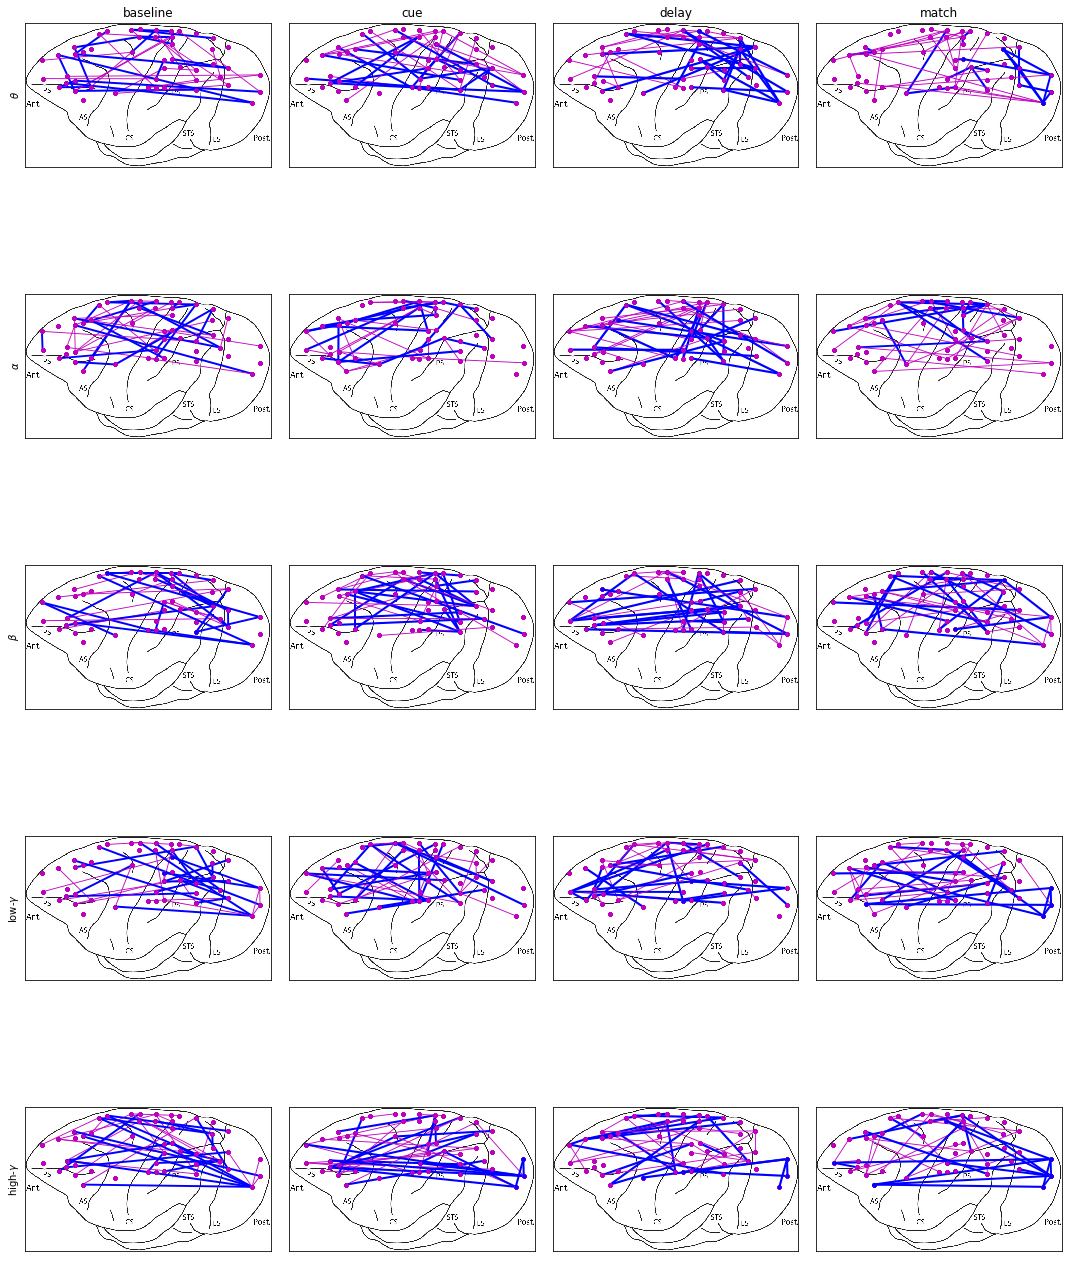

In [52]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b  = {}
    for i in range(len(stages)):     
        # Computing links' CV
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[i]])
        # Plotting top links
        plt.subplot(len(bands), len(stages), count)
        # Top 20 links
        top  = b[stages[i]][:,2].argsort()[:20]
        idx1 = np.zeros(b[stages[i]][:,2].shape[0])
        idx1[top] = 1
        # Bottom 20 links
        bot  = b[stages[i]][:,2].argsort()[-20:]
        idx2 = np.zeros(b[stages[i]][:,2].shape[0])
        idx2[bot] = 1
        #
        aux = 3*b[stages[i]][:,2]*idx1 - b[stages[i]][:,2]*idx2
        plot_edge_brain_sketch(net.session_info['pairs'], net.session_info['channels_labels'].astype(int), 
                               aux)
        if j == 0: plt.title(stages[i])
        if stages[i] == 'baseline': plt.ylabel(bands[j])
        count += 1
plt.tight_layout()

#### Burstness vs active time

100%|██████████| 5/5 [00:26<00:00,  5.29s/it]


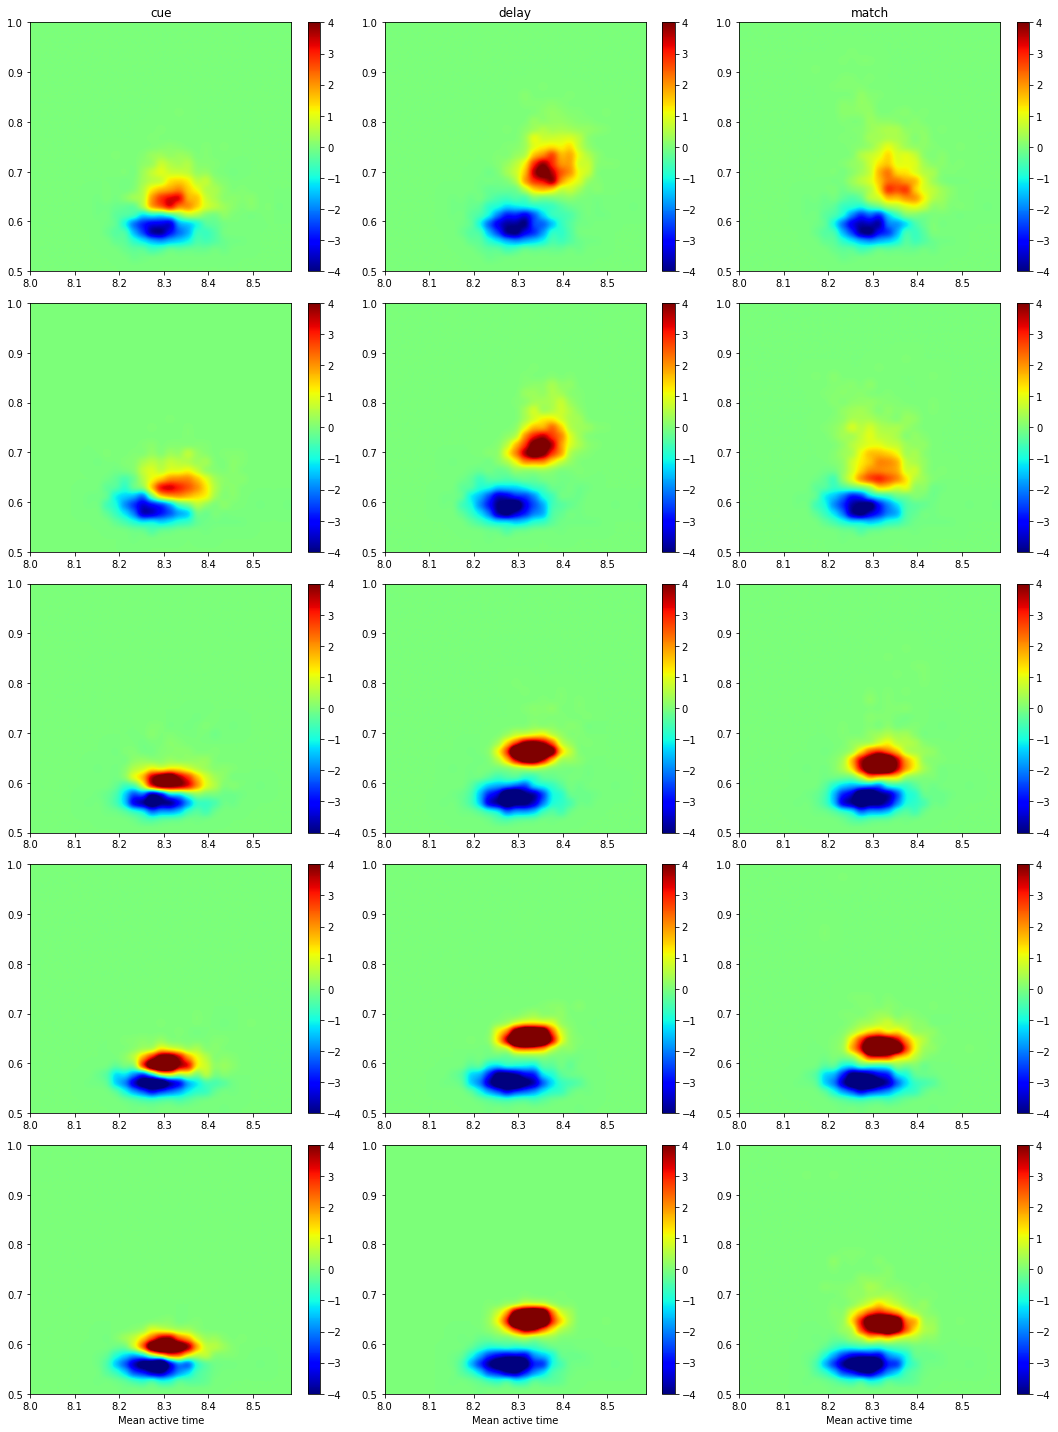

In [22]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b  = {}
    # Baseline
    b['baseline']  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[0]])
    Hb, xb, yb = np.histogram2d(b['baseline'][:,0], b['baseline'][:,2], 
                            bins=[np.linspace(8,25,30), np.linspace(0.5,1,30)], density = True  )
    for i in range(1,len(stages)):     
        # Computing links' CV
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[i]])
        # Plotting top links
        plt.subplot(len(bands), len(stages)-1, count)
        #plt.hist2d(b[stages[i]][:,0], b[stages[i]][:,2], bins=[np.linspace(8,25,30), np.linspace(0.5,1,30)] )
        H, xb, yb = np.histogram2d(b[stages[i]][:,0], b[stages[i]][:,2], 
                               bins=[np.linspace(8,25,30), np.linspace(0.5,1,30)], density = True )
        plt.imshow(H-Hb, aspect='auto', cmap='jet', origin='lower', 
                   extent=[xb[0],xb[1],yb[0],yb[-1]], interpolation='gaussian', vmin=-4, vmax=4)
        plt.colorbar()
        if j == 4: plt.xlabel('Mean active time')
        if j == 0: plt.title(stages[i])
        if stages[i] == 'baseline': plt.ylabel('Link CV, ' + bands[j])
        count += 1
plt.tight_layout()

#### Links' rates

In [23]:
r = np.zeros([len(bands), STb.shape[-1]])
for i in tqdm(range(len(bands))):
    r[i,:] = STb[:,i,:].sum(axis=0)

100%|██████████| 5/5 [00:01<00:00,  4.19it/s]


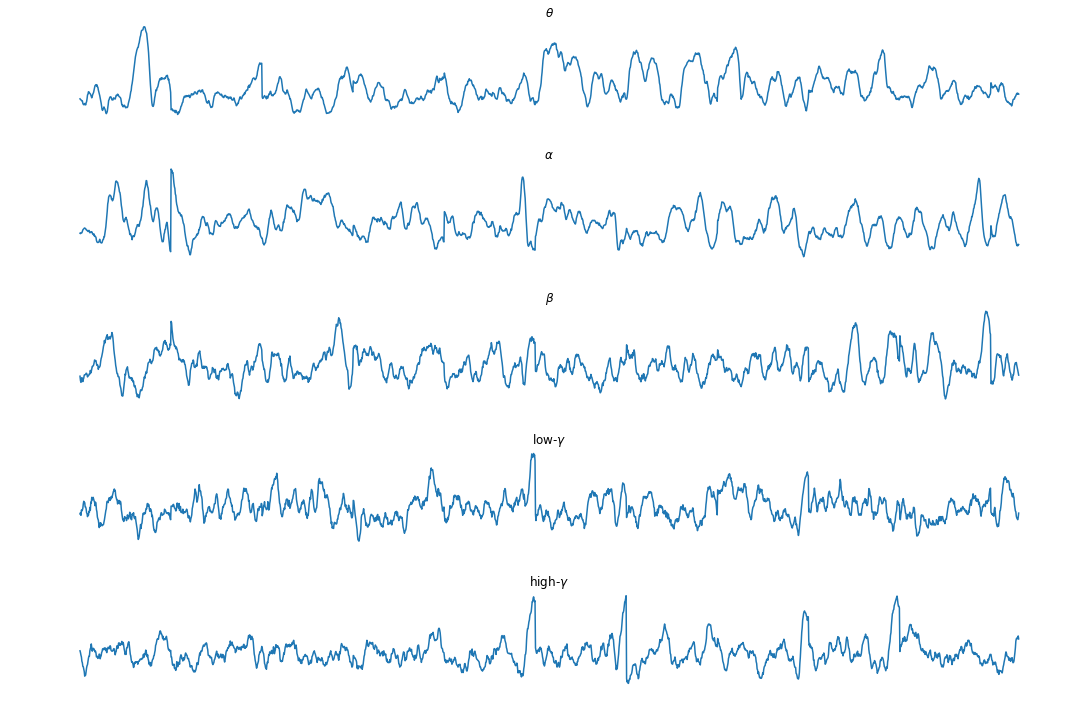

In [24]:
plt.figure(figsize=(15,10))
for i in range(len(bands)):
    plt.subplot(len(bands), 1, i+1)
    plt.plot(r[i,:2000])
    plt.title(bands[i])
    plt.axis('off')
plt.tight_layout()

In [25]:
cv = np.zeros([len(bands), len(stages)])
for j in tqdm( range(len(bands))):
    for i in range(len(stages)):
        aux = r[j,t_mask[i]]
        thr = scipy.stats.mstats.mquantiles(aux, prob=0.8)
        aux = aux > thr
        cv[j, i] = count_activations(aux)[-1]

100%|██████████| 5/5 [00:00<00:00, 72.21it/s]


#### Cross-frequency correlation

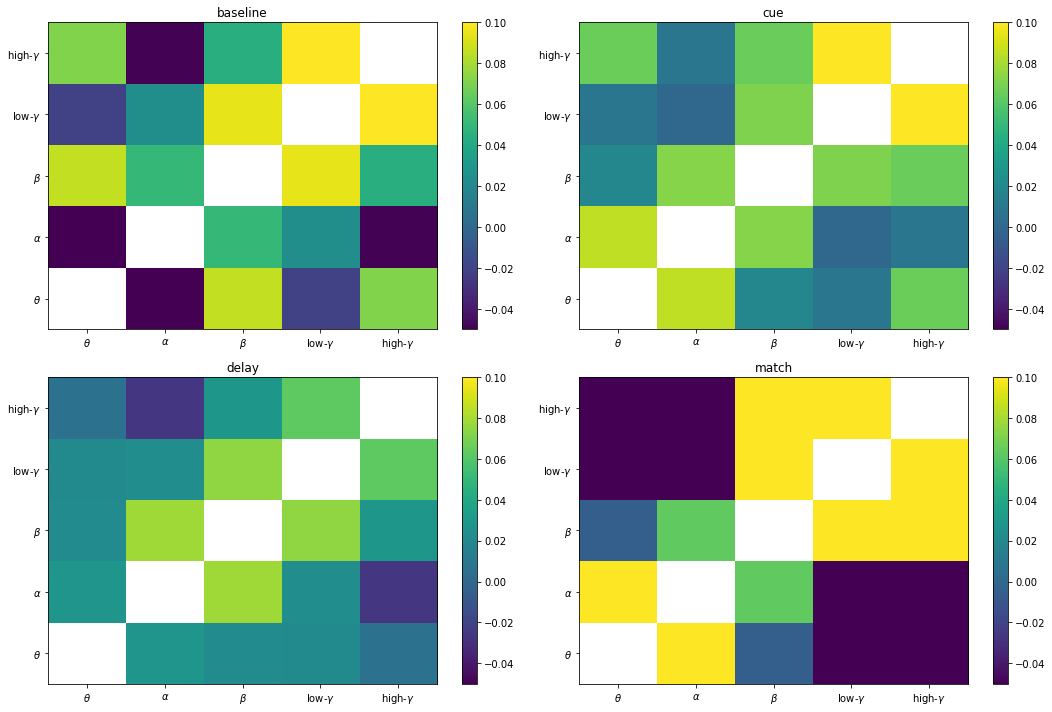

In [26]:
plt.figure(figsize=(15,10))
for s in range(len(stages)):
    cc_r = np.zeros([len(bands), len(bands)])
    for i in range(len(bands)):
        for j in range(len(bands)):
            if i is not j: cc_r[i,j] = np.corrcoef( r[i, t_mask[s]], r[j, t_mask[s]] )[0,1]
            else: cc_r[i,j] = np.nan
    plt.subplot(2,2,s+1)
    ax = plt.gca()
    plt.imshow(cc_r, aspect='auto', cmap='viridis', origin='lower', vmin=-0.05, vmax=0.1)
    plt.colorbar()
    plt.xticks(range(5), bands)
    plt.yticks(range(5), bands)
    plt.title(stages[s])
plt.tight_layout()

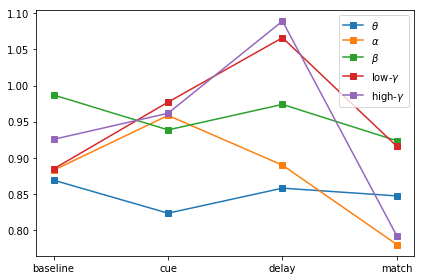

In [27]:
for i in range(len(bands)):
    plt.plot(cv[i], 's-', label=bands[i])
plt.legend()
plt.xticks(range(4), stages)
plt.tight_layout()

100%|██████████| 5/5 [00:00<00:00, 53.38it/s]


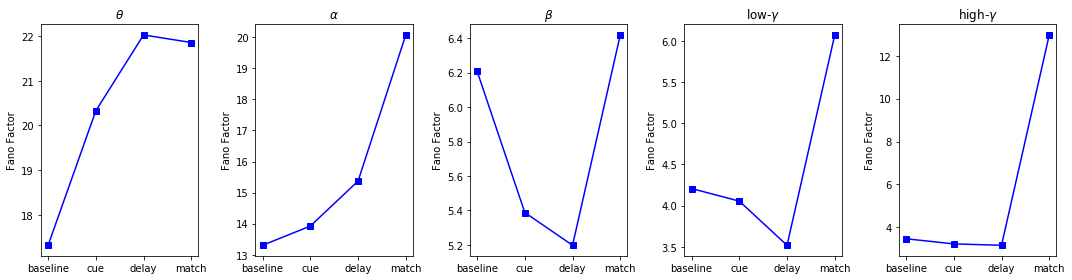

In [28]:
plt.figure(figsize=(15,4))
count = 1
ff  = np.zeros([len(bands), len(stages)])
for j in tqdm( range(len(bands)) ):
    plt.subplot(1, len(bands), count)
    for i in range(len(stages)):
        ff[j,i] = r[j,t_mask[i]].var() / r[j,t_mask[i]].mean() 
    plt.plot(ff[j,:], 'bs-')
    plt.ylabel('Fano Factor')
    plt.title(bands[j])
    plt.xticks(range(4), stages)
    count += 1
plt.tight_layout()

#### Dimensinality reduction on the raster plots

In [7]:
from MulticoreTSNE    import MulticoreTSNE as TSNE
from sklearn.manifold import TSNE

In [17]:
Y = TSNE(n_components=2, metric='hamming', perplexity=30.0, n_jobs=40).fit_transform(STb[:,1,:100*194].T)

/home/vinicius/.local/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


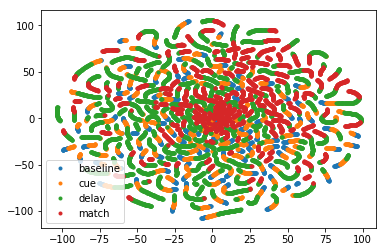

In [19]:
for i in range(len(stages)):
    plt.plot(Y[t_mask[i][:100*194],0], Y[t_mask[i][:100*194],1], '.', label = stages[i])
plt.legend()

100%|██████████| 4/4 [01:51<00:00, 27.82s/it]


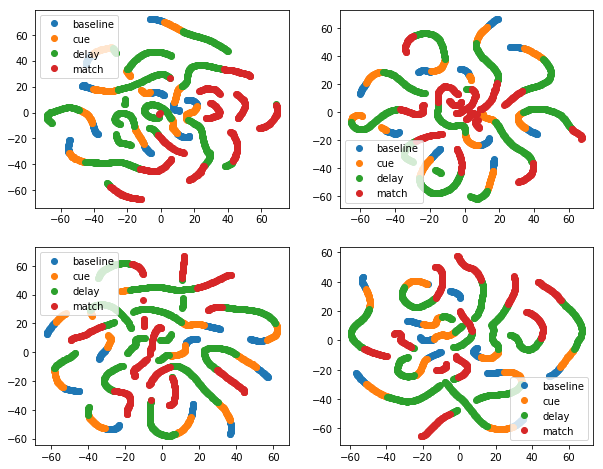

In [45]:
plt.figure(figsize=(10,8))
for i in tqdm( range(len(bands)-1) ):
    Y = TSNE(n_components=2, metric='hamming', perplexity=30.0).fit_transform(STb[:,i,:10*194].T)
    plt.subplot(2,2,i+1)
    for j in range(len(stages)):
        plt.plot(Y[t_mask[j][:10*194],0], Y[t_mask[j][:10*194],1], 'o', label = stages[j])
    if j == 3: plt.legend()
    plt.title()

#### Burstiness vs electrode distance

In [29]:
d_eu = np.zeros(net.session_info['pairs'].shape[0])
for i in range(net.session_info['pairs'].shape[0]):
    c1, c2 = net.session_info['channels_labels'].astype(int)[net.session_info['pairs'][i,0]], net.session_info['channels_labels'].astype(int)[net.session_info['pairs'][i,1]]
    dx = xy[c1-1,0] - xy[c2-1,0]
    dy = xy[c1-1,1] - xy[c2-1,1]
    d_eu[i] = np.sqrt(dx**2 + dy**2)

100%|██████████| 5/5 [00:26<00:00,  5.21s/it]


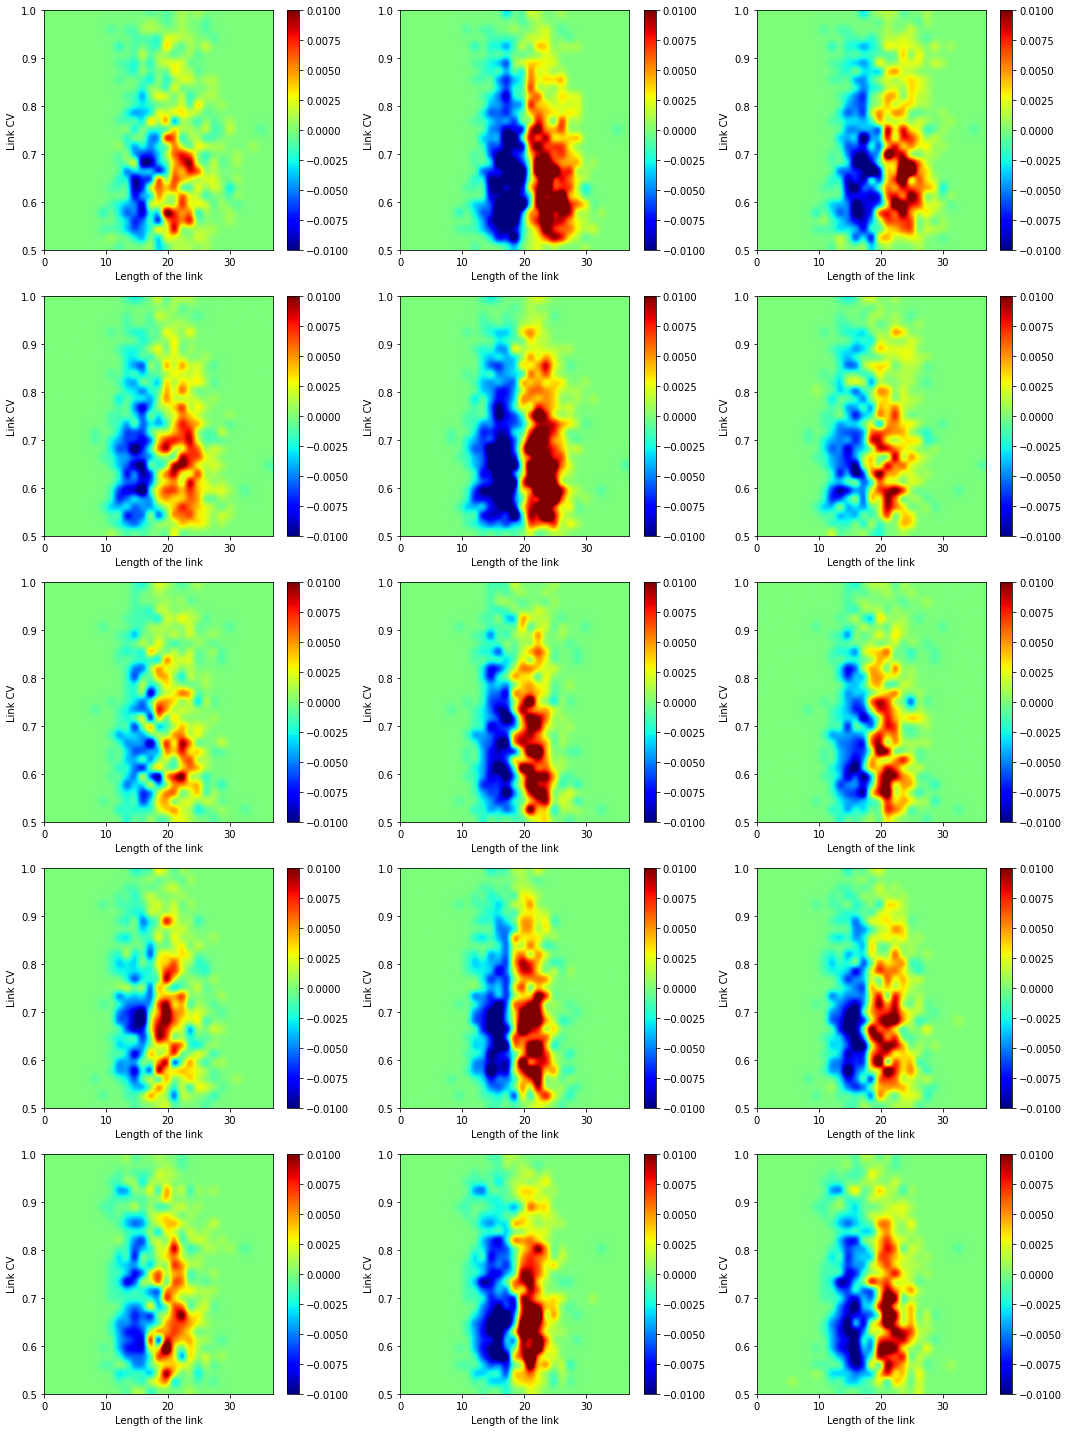

In [24]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b  = {}
    # Baseline
    b['baseline']  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[0]])
    Hb,xb,yb=np.histogram2d(d_eu, b['baseline'][:,2], 
                            bins=[np.linspace(0,d_eu.max(),30), np.linspace(0.5,1,30)],
                            density=True)
    for i in range(1, len(stages)):     
        # Computing links' CV
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[i]])
        # Plotting
        plt.subplot(len(bands), len(stages)-1, count)
        H,xb,yb=np.histogram2d(d_eu, b[stages[i]][:,2], 
                               bins=[np.linspace(0,d_eu.max(),30), np.linspace(0.5,1,30)],
                               density=True)
        plt.imshow(H-Hb, aspect='auto', cmap='jet', origin='lower', 
                   extent=[xb[0],xb[1],yb[0],yb[-1]], interpolation='gaussian', vmin=-0.01, vmax=0.01)
        plt.ylabel('Link CV')
        plt.colorbar()
        plt.xlabel('Length of the link')
        count+=1
plt.tight_layout()

#### Links' correlation

In [41]:
nP       = int( scipy.special.comb(net.session_info['nP'], 2) )
i, j     = np.tril_indices(net.session_info['nP'], k = -1)
pairs    = np.array([j,i]).T

In [ ]:
CCij = np.zeros([len(net.bands), net.session_info['nP'],net.session_info['nP'],len(stages)])
for b in tqdm( range(len(net.bands)) ):
    for s in range(len(stages)):
        aux = STb[:,b,t_mask[s]]
        L   = np.sum(t_mask[s])
        for i, j in pairs:
            CCij[b,i,j,s] = CCij[b,j,i,s] = np.sum(aux[i]*aux[j]) / L

  0%|          | 0/5 [00:00<?, ?it/s]

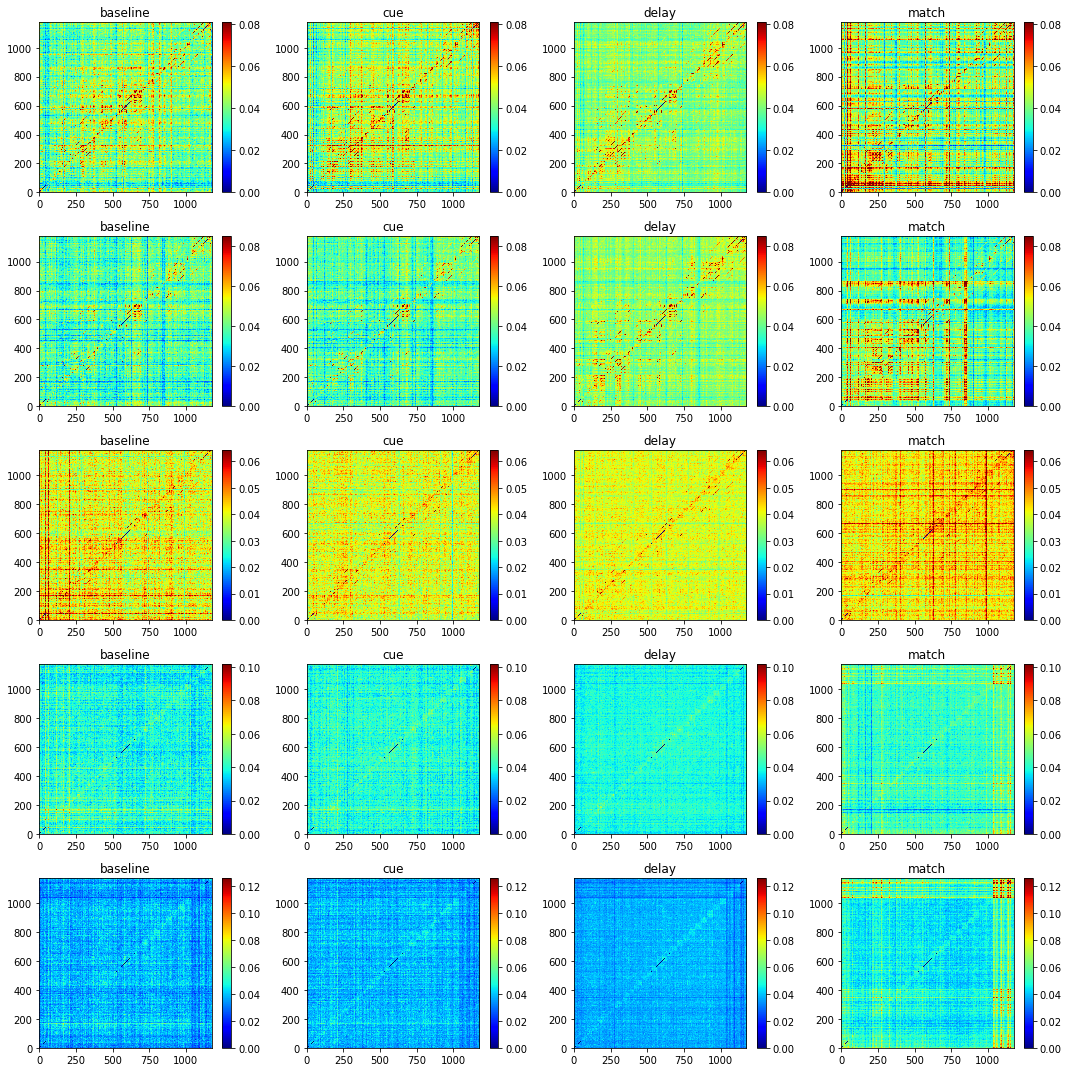

In [34]:
plt.figure(figsize=(15,15))
count = 1
for b in range(len(net.bands)):
    for i in range(len(stages)):
        plt.subplot(len(net.bands),len(stages),count)
        plt.imshow(CCij[b,:,:,i], aspect='auto', cmap='jet', origin='lower', vmax=CCij[b].max()/3)
        plt.title(stages[i])
        plt.colorbar()
        count+=1
plt.tight_layout()

### Cross-frequency coupling

### Comparison with fixation

In [31]:
# Instantiating a temporal network object specifing trim_borders and wt.
net_fx =  temporal_network(raw_path = '../super_tensors/', monkey='lucy', session=1, date=150128, align_to = 'cue', 
                           trial_type = 2, behavioral_response = None, trim_borders=True, wt_0=20, wt_1=30)

In [32]:
# Mask to track each stage of the ODRT
t_mask_fx = create_stages_time_grid(net_fx.session_info['t_cue_on'], net_fx.session_info['t_cue_off'], 
                                 net_fx.session_info['t_match_on'], net_fx.session_info['fsample'], 
                                 net_fx.tarray, net_fx.session_info['nT'])

In [33]:
STb_fx = np.zeros_like(net_fx.super_tensor)
for i in tqdm( range(len(net_fx.bands)) ):
    thr = scipy.stats.mstats.mquantiles(net_fx.super_tensor[:,i,:], prob=q_thr, axis=1)
    STb_fx[:,i,:] = net_fx.super_tensor[:,i,:] > thr

100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


100%|██████████| 5/5 [00:14<00:00,  2.87s/it]


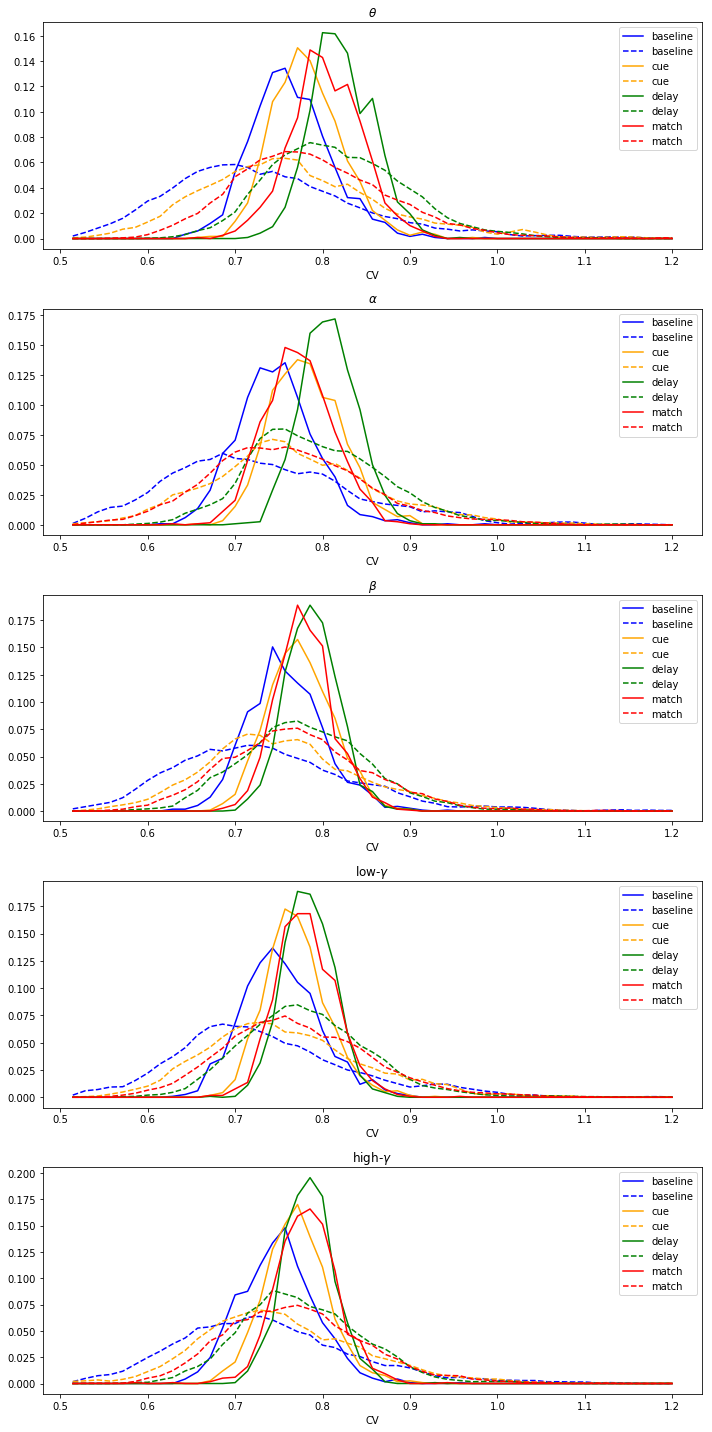

In [34]:
plt.figure(figsize=(10,20))
colors = ['b', 'orange', 'g', 'r']
for i in tqdm( range(len(net_fx.bands)) ):
    b     = {}
    b_fx  = {}
    plt.subplot(5,1,i+1)
    for j in range(len(stages)):
        # ODRT
        b[stages[j]]  = np.zeros([STb.shape[0], 3])
        b[stages[j]]  = np.apply_along_axis(count_activations, 1, STb[:,i,t_mask[j]])
        aux  = b[stages[j]][:,1]/b[stages[j]][:,0]
        c, x = np.histogram(aux, np.linspace(0.5,1.2,50))
        c    = c/c.sum()
        plt.plot(x[1:], c, label = stages[j], linestyle = '-', color = colors[j])        
        # FIXATION
        b_fx[stages[j]]  = np.zeros([STb_fx.shape[0], 3])
        b_fx[stages[j]]  = np.apply_along_axis(count_activations, 1, STb_fx[:,i,t_mask_fx[j]])
        aux = b_fx[stages[j]][:,1]/b_fx[stages[j]][:,0]
        c_fx, x_fx = np.histogram(aux, np.linspace(0.5,1.2,50))
        c_fx    = c_fx/c_fx.sum()
        plt.plot(x_fx[1:], smooth(c_fx,3), label = stages[j], linestyle = '--', color = colors[j])
    plt.legend()
    plt.xlabel('CV')
    plt.title(bands[i])
plt.tight_layout()

In [35]:
Y = TSNE(n_components=2, metric='hamming', perplexity=30.0, n_jobs=40).fit_transform(STb_fx[:,1,:100*194].T)

/home/vinicius/.local/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


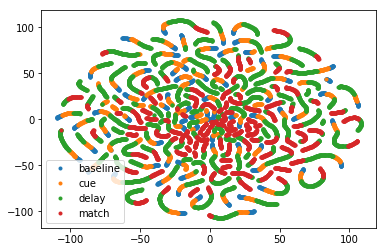

In [37]:
for i in range(len(stages)):
    plt.plot(Y[t_mask_fx[i][:100*194],0], Y[t_mask_fx[i][:100*194],1], '.', label = stages[i])
plt.legend()

#### Burstness vs active time

100%|██████████| 5/5 [00:17<00:00,  3.59s/it]


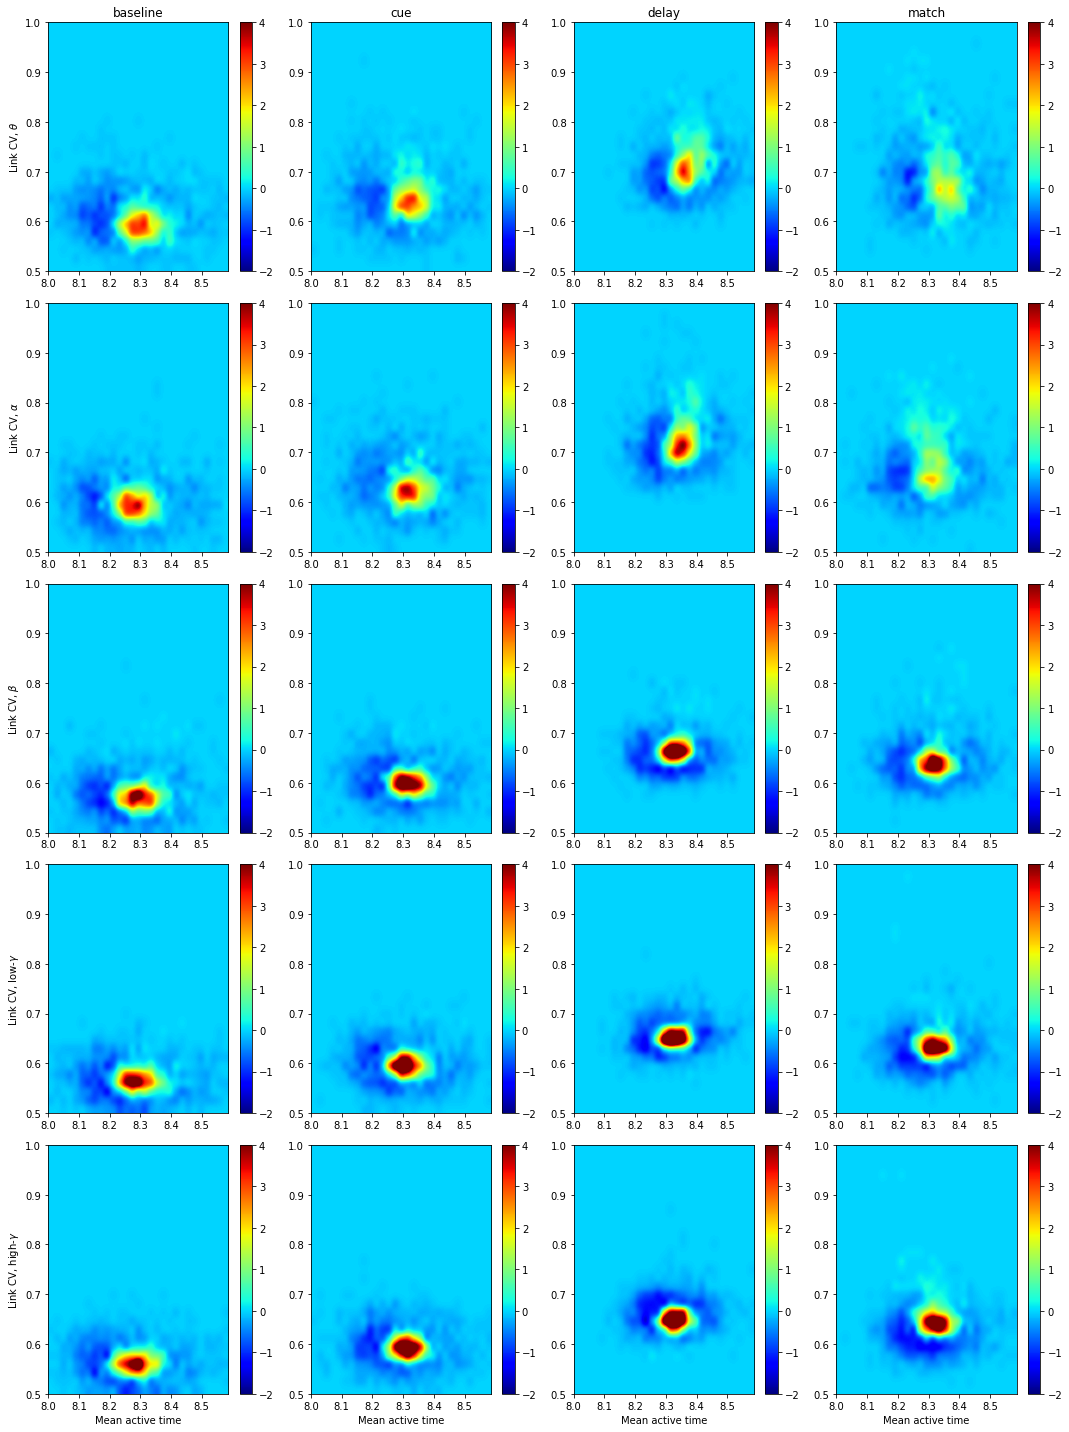

In [38]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b    = {}
    b_fx = {}
    for i in range(len(stages)):   
        plt.subplot(len(bands), len(stages), count)
        # ODRT
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[i]])
        H, xb, yb = np.histogram2d(b[stages[i]][:,0], b[stages[i]][:,2], 
                               bins=[np.linspace(8,25,30), np.linspace(0.5,1,30)], density = True )
        # FIXATION
        b_fx[stages[i]]  = np.apply_along_axis( count_activations, 1, STb_fx[:,j,t_mask_fx[i]])
        H_fx, xb_fx, yb_fx = np.histogram2d(b_fx[stages[i]][:,0], b_fx[stages[i]][:,2], 
                               bins=[np.linspace(8,25,30), np.linspace(0.5,1,30)], density = True )
        # PLOT
        plt.imshow(H-H_fx, aspect='auto', cmap='jet', origin='lower', 
                   extent=[xb[0],xb[1],yb[0],yb[-1]], interpolation='gaussian', vmin=-2, vmax=4)
        plt.colorbar()
        if j == 4: plt.xlabel('Mean active time')
        if j == 0: plt.title(stages[i])
        if stages[i] == 'baseline': plt.ylabel('Link CV, ' + bands[j])
        count += 1
plt.tight_layout()

#### Burstiness vs electrode distance

100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


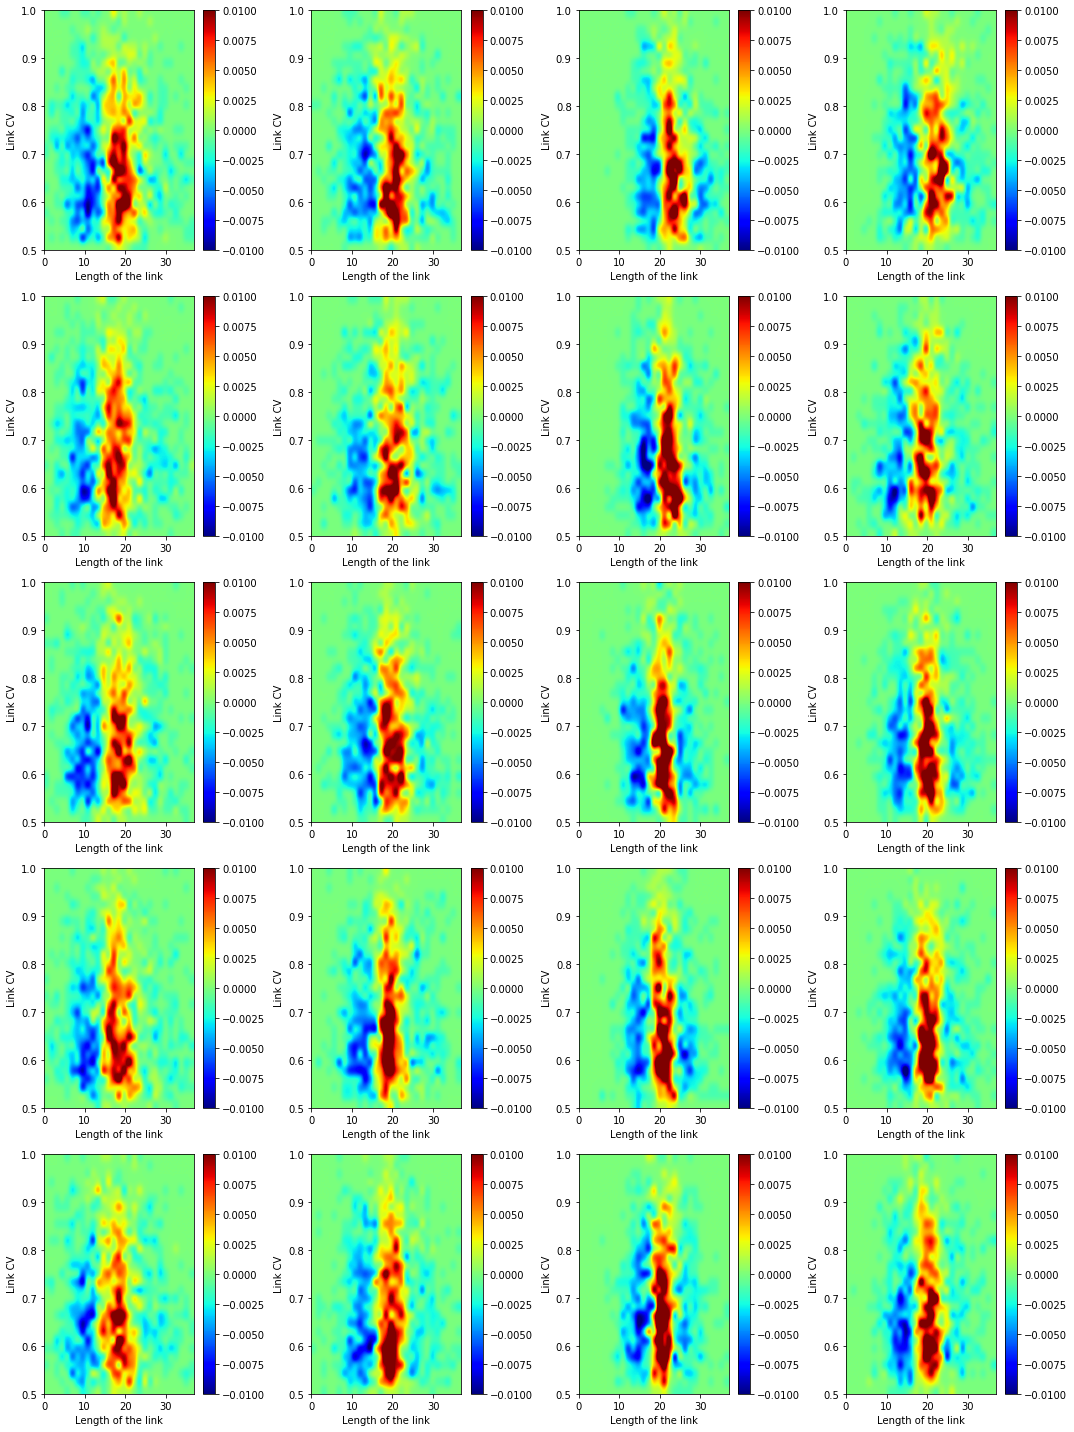

In [40]:
plt.figure(figsize=(15,20))
count = 1
for j in tqdm( range(len(bands)) ):
    b  = {}
    for i in range(len(stages)):     
        plt.subplot(len(bands), len(stages), count)
        # ODRT
        b[stages[i]]  = np.apply_along_axis( count_activations, 1, STb[:,j,t_mask[i]])
        H,xb,yb = np.histogram2d(d_eu, b[stages[i]][:,2], 
                               bins=[np.linspace(0,d_eu.max(),30), np.linspace(0.5,1,30)],
                               density=True)
        # FIXATION
        b_fx[stages[i]]  = np.apply_along_axis( count_activations, 1, STb_fx[:,j,t_mask_fx[i]])
        H_fx,xb_fx,yb_fx = np.histogram2d(d_eu, b_fx[stages[i]][:,2], 
                               bins=[np.linspace(0,d_eu.max(),30), np.linspace(0.5,1,30)],
                               density=True)
        # PLOTING
        plt.imshow(H-H_fx, aspect='auto', cmap='jet', origin='lower', 
                   extent=[xb[0],xb[1],yb[0],yb[-1]], interpolation='gaussian', vmin=-0.01, vmax=0.01)
        plt.ylabel('Link CV')
        plt.colorbar()
        plt.xlabel('Length of the link')
        count+=1
plt.tight_layout()